In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

from pathlib import Path

import functions.data_wrangling as data
import functions.eddy_feedback as ef

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

### Define function

This function is taken from the regridded [version](/home/links/ct715/eddy_feedback/research/Post-upgrade/efp_components.ipynb) and slightly modified.

In [15]:
def plot_multiple_components_cbar(datasets_dict, data_type=None, calc_south_hemis=False):
    """
    Plot zonal mean components for multiple datasets in a grid with up to 3 rows per column.

    Parameters:
    - datasets_dict: Dictionary of datasets to plot (keys are dataset labels, values are datasets).
    - data_type: Type of dataset ('reanalysis', 'reanalysis_qg', 'pamip', or 'isca').
    - calc_south_hemis: Whether to calculate for the Southern Hemisphere.
    """

    # set different data types and the corresponding EP flux name
    data_type_mapping = {
        'reanalysis': 'div1_pr',
        'reanalysis_qg': 'div1_qg',
        'pamip': 'divFy',
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')
    which_div1 = data_type_mapping.get(data_type)

    # Number of datasets
    N = len(datasets_dict)
    
    # Determine the number of rows and columns (3 rows max per column)
    max_rows = 3
    ncols = (N // max_rows) + (N % max_rows > 0)
    nrows = min(N, max_rows)
    
    # Set up the figure with the appropriate number of rows and columns
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharey=True)

    # If there's only one subplot, axs will not be a 2D array. This fixes that.
    if N == 1:
        axs = [[axs]]
    elif N <= max_rows:
        axs = [axs]  # Convert to 2D array with 1 column
    else:
        axs = np.reshape(axs, (nrows, ncols))

    # Define color scale limits and colormap
    vmin = -5e-5
    vmax = 5e-5
    cmap = 'RdBu_r'  # Diverging colormap, blue for negative, red for positive values

    # Loop over the datasets and plot for each
    for i, (label, ds) in enumerate(datasets_dict.items()):
        row = i % max_rows
        col = i // max_rows

        # Check dimensions and adjust dataset if necessary
        correct_dims = all(dim_name in ds.dims for dim_name in ['time', 'level', 'lat'])
        if not correct_dims:
            ds = data.check_dimensions(ds, ignore_dim='lon')
        ds = data.check_coords(ds)

        # Calculate Eddy Feedback Parameter (EFP)
        efp_value = ef.calculate_efp(ds, data_type=data_type, calc_south_hemis=calc_south_hemis)

        if 'ens_ax' in ds.dims:
            mean = ('time', 'ens_ax')
        else:
            mean = ('time')

        # Select latitude and level range
        if not calc_south_hemis:
            ds = ds.sel(lat=slice(0, 90))
            season = 'djf'
        else:
            ds = ds.sel(lat=slice(-90, 0))
            season = 'jas'
        ds = ds.sel(level=slice(1000, 50))

        # Right-hand subplot (mean fields)
        ax = axs[row][col]
        ds.ubar.mean(mean).plot.contour(ax=ax, levels=20, yincrease=False, colors='k')
        div1_plot = ds[which_div1].mean(mean).plot.contourf(
            ax=ax,
            levels=np.linspace(vmin, vmax, 21),  # Ensure the same color scale for all plots
            yincrease=False,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            extend='both',  # Extend colorbar for values outside the specified range
            cbar_kwargs={'location': 'bottom', 'shrink': 0.75, 'label': 'DivFy'}
        )
        ax.set_title(f'{label} (EFP={efp_value})')

        # Plot EFP box
        rect = patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2, color='limegreen')
        ax.add_patch(rect)

        # Remove Y-label on the right-hand subplots
        if col > 0:
            ax.set_ylabel('')
            
    # Hide unused subplots
    total_plots = nrows * ncols
    for i in range(N, total_plots):
        row = i % max_rows
        col = i // max_rows
        axs[row][col].axis('off')  # Hide unused subplot

    # Adjust layout to avoid overlapping
    plt.tight_layout()
    plt.show()


### Import data and make plot

Here we extract the model names from the required directory, so that we can use these for our model keys in the dictionary.

In [16]:
directory_path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/')

# Initialize an empty list to store the model names
model_names = []
# Iterate through the files in the directory
for file in directory_path.iterdir():
    if file.is_file() and file.suffix == ".nc":
        # Extract the stem (filename without extension)
        filename_stem = file.stem
        # Split by underscore and take the first part (MODEL)
        model_name = filename_stem.split('_')[0]
        # Append the model name to the list
        model_names.append(model_name)
        
# sort the models alphabetically
model_names.sort()

In [17]:
ds_models = {}
for model in model_names:
    
    # set file directory
    file_dir = directory_path.glob(f'{model}*.nc')
    # import data
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True
    )
    
    # subset data
    dataset = dataset.where(dataset.level < 1000.)
    dataset = dataset.where(dataset.lat < 90.)
    
    # save to dictionary
    ds_models[model] = dataset
    
del ds_models['E3SMv1']
del ds_models['ECHAM6.3']
len(ds_models)

13

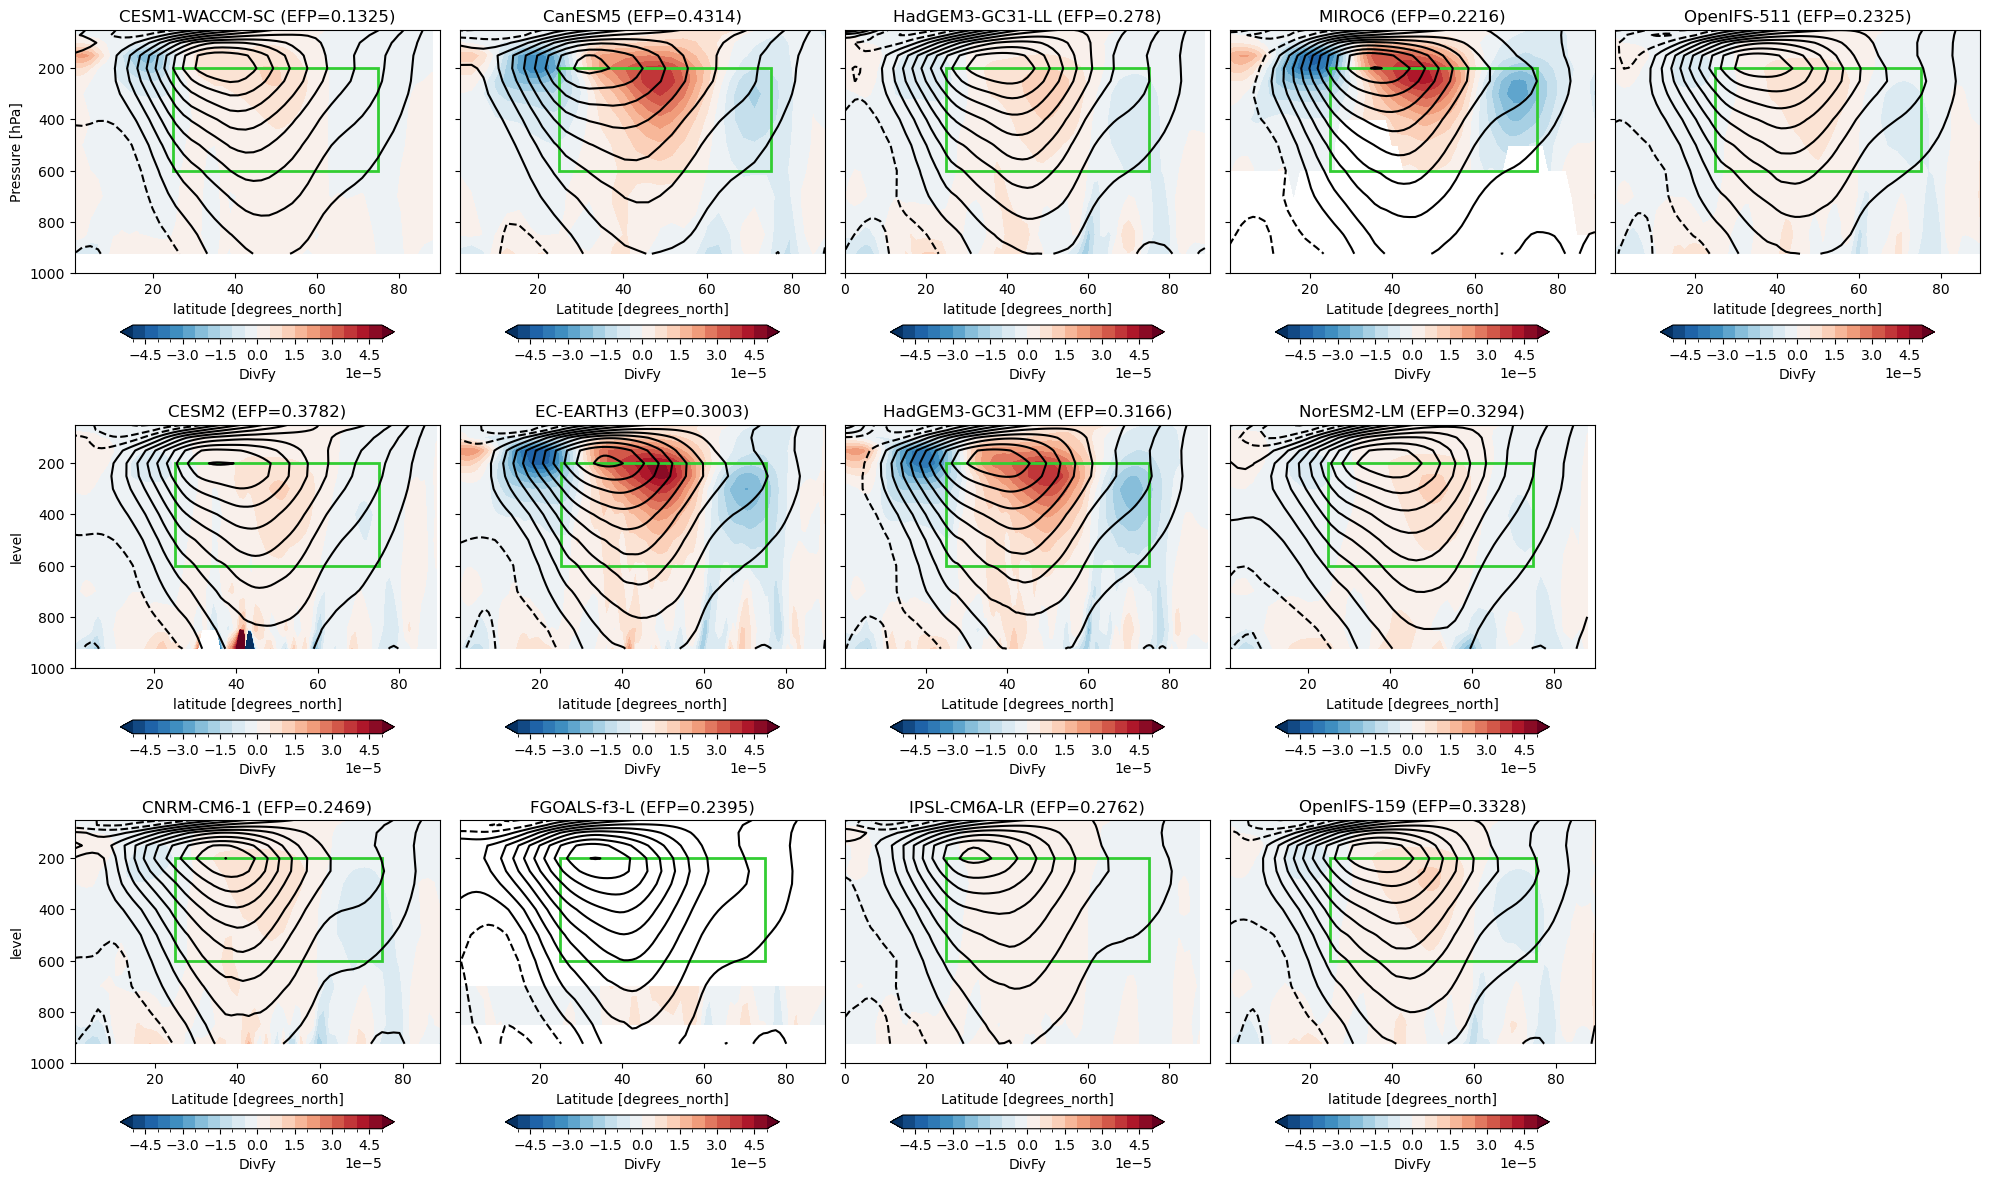

In [18]:
plot_multiple_components_cbar(ds_models, data_type='pamip')